# **Простейшая рекомендательная система**

Такие РС реализованы на основе popularity-based подхода, т.е. работают с реакциями потребителей. 

Мы будем работать с набором данных Movie Lens. Он содержит идентификаторы для каждого фильма и пользователя, который его смотрел, а также оценку, которую пользователь поставил фильму. В датасете представлено 20 000 263 оценок фильмов от 138493 пользователя со шкалой оценок от 0.5 до 5.0.

Из этого набора нам понадобится два файла:
- [данные о фильмах (movies)](https://lms-cdn.skillfactory.ru/assets/courseware/v1/4dc5c1a1e1cc649c1c263450521a00b1/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/movie.zip);
- [данные о выставленных оценках (ratings)](https://drive.google.com/file/d/1HwsPtZ3I9skYVI0EQCGO_nyagJH9aG-E/view?usp=sharing).

## Загрузка инструментария

In [27]:
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Загрузка данных

In [2]:
ratings = pd.read_csv('ratings.csv')
print('Shape of ratings data:', ratings.shape)
ratings.head()

Shape of ratings data: (20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
movies = pd.read_csv('movie.zip')
print('Shape of movies data:', movies.shape)
movies.head()

Shape of movies data: (27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Объединим их:

In [4]:
df=pd.merge(ratings,movies, how='left',on='movieId')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Признаки в данных

|feature|description|feature|description|
|-|-|-|-|
|`userId`|id пользователя|`timestamp`|время выставления рейтинга|
|`movieId`|id фильма|`title`|название фильма|
|`rating`|выставленный пользователем рейтинг для фильма|`genres`|жанры, к которым относится фильм|

## Анализ и обработка данных

Для начала подсчитаем, сколько раз каждый фильм встречается в наборе данных. Выведем топ-5 фильмов по популярности.

In [25]:
movie_counts = df.title.value_counts()
movie_counts[:5]

Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: title, dtype: int64

Отлично, мы нашли самые востребованные фильмы. Однако если фильм посмотрело много людей, это ещё не значит, что он им понравился. Чтобы понять, как зритель на самом деле относится к фильму, нужны более чёткие данные. К счастью, в наборе данных Movie Lens есть оценки каждого из зрителей.

Поэтому далее мы попробуем найти:

- средний рейтинг для каждого из фильмов;
- фильмы с наивысшим средним рейтингом;
- фильм, занимающий последнее место среди фильмов с наивысшим рейтингом, если предварительно отсортировать их по алфавитному порядку.

In [76]:
movies_ratings = df.groupby('title', as_index=False)['rating'].mean()
movies_ratings.head(3)

,title,rating
0,#chicagoGirl: The Social Network Takes on a Di...,3.666667
1,$ (Dollars) (1971),2.833333
2,$5 a Day (2008),2.871795


Средние рейтинги посчитаны, отсортируем нашу таблицу сгруппированных по названиям фильмов данных.

In [77]:
movies_ratings_sorted = movies_ratings.sort_values(['rating','title'], ascending=[False, True])
movies_ratings_sorted.query('rating == 5')[-3:]

,title,rating
25918,Who Killed Vincent Chin? (1987),5.0
26430,Year Zero: The Silent Death of Cambodia (1979),5.0
26482,Yonkers Joe (2008),5.0


Мы использовали два самых простых метода для создания неперсонализированных рекомендаций: рекомендации по пополярности фильмов и рекомендации по средней оценке. Однако оба метода имеют свои существенные недостатки: поиск наиболее часто просматриваемых фильмов не учитывает того, насколько фильм нравится аудитории, а поиск среднего рейтинга может вывести в рекомендуемые фильмы малоизвестные специфические картины с одной-двумя оценками.

Чтобы решить эти проблемы, объединим два подхода и рассчитаем байесовское среднее для рейтинга каждого фильма.

**Байесовское среднее** — это статистический метод, используемый для более объективного ранжирования объектов (например, фильмов, товаров или пользователей) на основе их оценок, особенно когда у некоторых объектов очень мало оценок. Этот подход позволяет сгладить эффект небольшого количества голосов и учесть априорные знания.

Мы также добавим экспоненциальный штраф, чтобы фильмы с малым числом оценок, являющихся к тому же высокими, не забивали топ списка.

In [63]:
def calculate_adjusted_rating(df, quantile=0.6, N=50, base_rating=5):
    """
    Вычисляет скорректированный рейтинг фильмов с усиленным штрафом для фильмов с малым количеством оценок,
    используя гибридный метод Байесовской средней и квантильного порога.
    
    Параметры:
    df (pd.DataFrame): Датафрейм, содержащий столбцы 'num_votes' и 'avg_rating'.
    quantile (float): Квантиль для определения порога количества голосов. Значение по умолчанию - 0.6.
    N (int): Априорное количество голосов для Байесовской средней. По умолчанию - 50.
    base_rating (float): Базовая оценка для фильмов с малым количеством голосов. По умолчанию - 5.
    
    Возвращает:
    pd.DataFrame: Исходный датафрейм с добавленным столбцом 'adjusted_rating'.
    """
    
    if 'num_votes' not in df.columns or 'avg_rating' not in df.columns:
        raise ValueError("Датафрейм должен содержать столбцы 'num_votes' и 'avg_rating'.")

    # Определяем порог количества голосов на основе квантиля
    C = df['num_votes'].quantile(quantile)
    
    # Извлекаем значения количества голосов и среднего рейтинга
    v = df['num_votes'].values
    R = df['avg_rating'].values
    
    # Экспоненциальный штраф для фильмов с малым количеством оценок
    penalty = np.exp(-v / C)  # Чем меньше голосов, тем сильнее штраф
    
    # Вычисляем скорректированный рейтинг с учетом штрафа
    adjusted_ratings = (v / (v + C) * R) + (C / (v + C) * (N / (N + v) * base_rating + v / (N + v) * R)) * (1 - penalty)
    
    # Добавляем новый столбец с отрегулированным рейтингом
    df['adjusted_rating'] = adjusted_ratings
    
    return df

Сгруппируем данные.

In [78]:
# Группируем данные
grouped_df = df.groupby(['movieId', 'title']).agg(
    num_votes=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

grouped_df.head()

,movieId,title,num_votes,avg_rating
0,1,Toy Story (1995),49695,3.921240
1,2,Jumanji (1995),22243,3.211977
2,3,Grumpier Old Men (1995),12735,3.151040
3,4,Waiting to Exhale (1995),2756,2.861393
4,5,Father of the Bride Part II (1995),12161,3.064592


Отрисуем графику.

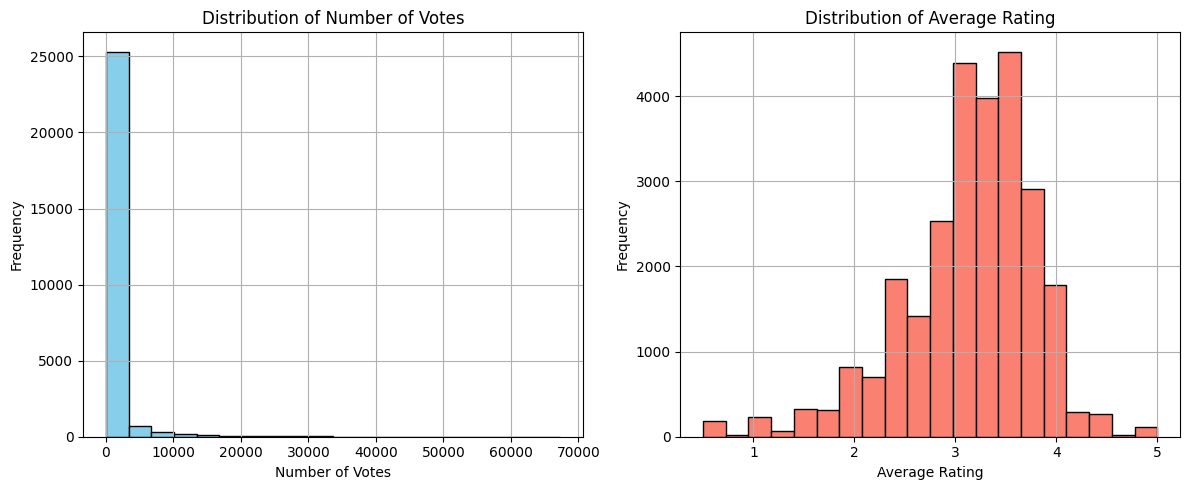

In [79]:
# Создаем фигуру и оси
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 ряд, 2 колонки

# Строим первую гистограмму
grouped_df['num_votes'].hist(ax=axes[0], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Number of Votes')
axes[0].set_xlabel('Number of Votes')
axes[0].set_ylabel('Frequency')

# Строим вторую гистограмму
grouped_df['avg_rating'].hist(ax=axes[1], bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Average Rating')
axes[1].set_xlabel('Average Rating')
axes[1].set_ylabel('Frequency')

# Показываем график
plt.tight_layout()  # Убираем лишние пробелы
plt.show()

Надо также отделить год производства фильма от названия и поместим первые в новый столбец. А если между словами в названиях будет несколько пробелов, то заменить их на один.

In [95]:
def separate_title_year(df):
    def extract_year_and_title(row):
        # Регулярное выражение для поиска года в скобках в конце строки
        match = re.search(r'\((\d{4})\)$', row['title'])
        if match:
            year = int(match.group(1))
            # Удаляем год и скобки из названия
            title = re.sub(r'\s*\(\d{4}\)$', '', row['title'])
        else:
            # Если год не найден, оставляем исходное название и устанавливаем год как NaN
            title = row['title']
            year = '-'
        
        # Нормализуем пробелы в названии
        title = ' '.join(title.split())
        
        return title, year

    # Создаем копию датафрейма, чтобы избежать предупреждений о изменении копии
    new_df = df.copy()
    
    # Применяем функцию extract_year_and_title к столбцу 'title'
    new_df['title'], new_df['prod_year'] = zip(*new_df.apply(extract_year_and_title, axis=1))
    
    return new_df

In [96]:
# Вычисляем скорректированный рейтинг
df_with_adjusted_ratings = calculate_adjusted_rating(grouped_df, quantile=0.6, N=100)

df_with_adjusted_ratings_title_year_separated = separate_title_year(
    df_with_adjusted_ratings
    )

# Сортируем DataFrame по 'adjusted_rating' в порядке убывания
sorted_df = df_with_adjusted_ratings_title_year_separated.sort_values(
    by='adjusted_rating', ascending=False
    )

# Выводим отсортированный DataFrame
print('Top-10:')
display(sorted_df[:10])
print('Anti-top-10:')
display(sorted_df[-10:])

Top-10:


,movieId,title,num_votes,avg_rating,adjusted_rating,prod_year
315,318,"Shawshank Redemption, The",63366,4.446990,4.446991,1994
843,858,"Godfather, The",41355,4.364732,4.364734,1972
49,50,"Usual Suspects, The",47006,4.334372,4.334374,1995
523,527,Schindler's List,50054,4.310175,4.310176,1993
1195,1221,"Godfather: Part II, The",27398,4.275641,4.275645,1974
1935,2019,Seven Samurai (Shichinin no samurai),11611,4.274180,4.274205,1954
887,904,Rear Window,17449,4.271334,4.271345,1954
7356,7502,Band of Brothers,4305,4.263182,4.263363,2001
895,912,Casablanca,24349,4.258327,4.258333,1942
905,922,Sunset Blvd. (a.k.a. Sunset Boulevard),6525,4.256935,4.257015,1950


Anti-top-10:


,movieId,title,num_votes,avg_rating,adjusted_rating,prod_year
22767,109381,"Paimen, piika ja emäntä",1,0.5,0.112565,1938
24778,118346,Night Terrors,1,0.5,0.112565,1993
22757,109359,Gerontophilia,1,0.5,0.112565,2013
22173,107106,Dead Weekend,1,0.5,0.112565,1995
24966,119214,Food Stamped,1,0.5,0.112565,2010
22756,109355,13 Fighting Men,1,0.5,0.112565,1960
18534,92479,Kisses for My President,1,0.5,0.112565,1964
26407,129456,The Legend of Bloody Jack,1,0.5,0.112565,2007
10120,33581,Bad Boy (Dawg),1,0.5,0.112565,2002
25599,124963,House Party: Tonight's the Night,1,0.5,0.112565,2013


По сути, мы только что построили простейшую рекомендательную систему.